# 彼得與狼：真實環境

在我們的情境中，彼得幾乎可以四處移動而不感到疲倦或飢餓。在更真實的世界中，他需要時不時坐下休息，並且還需要進食。讓我們通過實現以下規則，使我們的世界更加真實：

1. 從一個地方移動到另一個地方時，彼得會失去**能量**並增加一些**疲勞**。
2. 彼得可以通過吃蘋果來獲得更多能量。
3. 彼得可以通過在樹下或草地上休息來消除疲勞（即走到有樹或草的棋盤位置——綠色區域）。
4. 彼得需要找到並殺死狼。
5. 為了殺死狼，彼得需要達到一定的能量和疲勞水平，否則他會輸掉戰鬥。


In [1]:
import matplotlib.pyplot as plt
import numpy as np
import random
import math
from rlboard import *

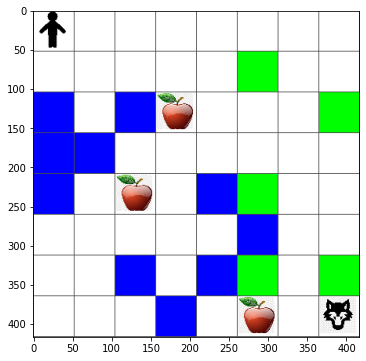

In [2]:
width, height = 8,8
m = Board(width,height)
m.randomize(seed=13)
m.plot()

In [3]:
actions = { "U" : (0,-1), "D" : (0,1), "L" : (-1,0), "R" : (1,0) }
action_idx = { a : i for i,a in enumerate(actions.keys()) }

## 定義狀態

在我們的新遊戲規則中，我們需要追蹤每個棋盤狀態下的能量和疲勞。因此，我們將創建一個名為 `state` 的物件，該物件將包含有關當前問題狀態的所有必要資訊，包括棋盤的狀態、當前的能量和疲勞水平，以及在終端狀態下是否能擊敗狼：


In [4]:
class state:
    def __init__(self,board,energy=10,fatigue=0,init=True):
        self.board = board
        self.energy = energy
        self.fatigue = fatigue
        self.dead = False
        if init:
            self.board.random_start()
        self.update()

    def at(self):
        return self.board.at()

    def update(self):
        if self.at() == Board.Cell.water:
            self.dead = True
            return
        if self.at() == Board.Cell.tree:
            self.fatigue = 0
        if self.at() == Board.Cell.apple:
            self.energy = 10

    def move(self,a):
        self.board.move(a)
        self.energy -= 1
        self.fatigue += 1
        self.update()

    def is_winning(self):
        return self.energy > self.fatigue

讓我們嘗試使用隨機漫步來解決這個問題，看看我們是否成功：


In [5]:
def random_policy(state):
    return random.choice(list(actions))

def walk(board,policy):
    n = 0 # number of steps
    s = state(board)
    while True:
        if s.at() == Board.Cell.wolf:
            if s.is_winning():
                return n # success!
            else:
                return -n # failure!
        if s.at() == Board.Cell.water:
            return 0 # died
        a = actions[policy(m)]
        s.move(a)
        n+=1

walk(m,random_policy)

0

In [6]:
def print_statistics(policy):
    s,w,n = 0,0,0
    for _ in range(100):
        z = walk(m,policy)
        if z<0:
            w+=1
        elif z==0:
            n+=1
        else:
            s+=1
    print(f"Killed by wolf = {w}, won: {s} times, drown: {n} times")

print_statistics(random_policy)

Killed by wolf = 5, won: 1 times, drown: 94 times


## 獎勵函數

獎勵函數是強化學習中至關重要的一部分。它定義了代理在特定情況下應該獲得的回饋，從而指導代理學習如何達成目標。

### 設計獎勵函數的原則

設計一個有效的獎勵函數需要謹慎考慮，因為它直接影響代理的行為。以下是一些設計原則：

1. **與目標一致**  
   獎勵應該清楚地反映代理的最終目標。模糊或矛盾的獎勵可能會導致意想不到的行為。

2. **避免過度激勵**  
   過高的獎勵可能會導致代理過度專注於某些行為，而忽略其他重要的目標。

3. **考慮長期影響**  
   獎勵函數應該考慮行為的長期影響，而不僅僅是短期回報。

### 範例

以下是一個簡單的範例，展示如何設計一個獎勵函數：

```python
def reward_function(state, action):
    if state == "goal":
        return 10  # 達到目標時的高獎勵
    elif action == "illegal":
        return -5  # 違規行為的懲罰
    else:
        return -1  # 每一步的成本
```

在這個範例中，代理會被激勵去達成目標，同時避免違規行為。

### 常見問題

#### 如何處理稀疏獎勵？
稀疏獎勵可能會導致學習過程變慢。為了解決這個問題，可以考慮使用以下方法：
- 提供中間獎勵，幫助代理逐步接近目標。
- 使用潛在學習技術，讓代理學習隱含的目標。

#### 獎勵函數是否需要完美？
不需要。雖然一個好的獎勵函數可以加速學習，但即使是次優的獎勵函數，代理也能通過探索找到解決方案。

### 總結

獎勵函數是強化學習的核心部分。設計一個清晰且與目標一致的獎勵函數，可以幫助代理更快地學習並達成目標。


In [7]:
def reward(s):
    r = s.energy-s.fatigue
    if s.at()==Board.Cell.wolf:
        return 100 if s.is_winning() else -100
    if s.at()==Board.Cell.water:
        return -100
    return r

## Q-Learning 演算法

實際的學習演算法幾乎保持不變，我們只是使用 `state` 而不是僅僅使用棋盤位置。


In [8]:
Q = np.ones((width,height,len(actions)),dtype=np.float)*1.0/len(actions)

In [9]:
def probs(v,eps=1e-4):
    v = v-v.min()+eps
    v = v/v.sum()
    return v

In [10]:

from IPython.display import clear_output

lpath = []

for epoch in range(10000):
    clear_output(wait=True)
    print(f"Epoch = {epoch}",end='')

    # Pick initial point
    s = state(m)
    
    # Start travelling
    n=0
    cum_reward = 0
    while True:
        x,y = s.board.human
        v = probs(Q[x,y])
        while True:
            a = random.choices(list(actions),weights=v)[0]
            dpos = actions[a]
            if s.board.is_valid(s.board.move_pos(s.board.human,dpos)):
                break 
        s.move(dpos)
        r = reward(s)
        if abs(r)==100: # end of game
            print(f" {n} steps",end='\r')
            lpath.append(n)
            break
        alpha = np.exp(-n / 3000)
        gamma = 0.5
        ai = action_idx[a]
        Q[x,y,ai] = (1 - alpha) * Q[x,y,ai] + alpha * (r + gamma * Q[x+dpos[0], y+dpos[1]].max())
        n+=1

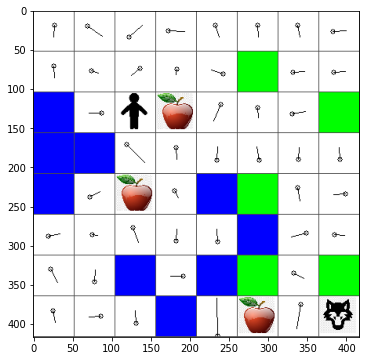

In [11]:
m.plot(Q)

## 結果

讓我們看看是否成功訓練彼得對抗狼！


In [12]:
def qpolicy(m):
        x,y = m.human
        v = probs(Q[x,y])
        a = random.choices(list(actions),weights=v)[0]
        return a

print_statistics(qpolicy)

Killed by wolf = 1, won: 9 times, drown: 90 times


我們現在看到溺水的案例少了很多，但彼得仍然無法總是殺死狼。嘗試進行實驗，看看是否可以通過調整超參數來改善這個結果。


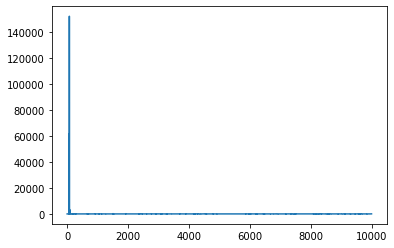

In [13]:
plt.plot(lpath)


---

**免責聲明**：  
本文件使用 AI 翻譯服務 [Co-op Translator](https://github.com/Azure/co-op-translator) 進行翻譯。我們致力於提供準確的翻譯，但請注意，自動翻譯可能包含錯誤或不準確之處。應以原始語言的文件作為權威來源。對於關鍵資訊，建議尋求專業人工翻譯。我們對因使用此翻譯而產生的任何誤解或錯誤解讀概不負責。
